In [20]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
import imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
def image_loader(content_image, style_image, target_size):
    c_image = Image.open(content_image)
    s_image = Image.open(style_image)

    width, height = c_image.size
    aspect_ratio = width / height

    if width > height:
        width = target_size
        height = round(width / aspect_ratio)
    else:
        height = target_size
        width = round(height * aspect_ratio)

    loader = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor()
    ])  

    c_image = loader(c_image).unsqueeze(0)
    s_image = loader(s_image).unsqueeze(0)
    return (
        c_image.to(device, torch.float),
        s_image.to(device, torch.float)
    )

In [4]:
def to_pil(tensor):
    unloader = transforms.ToPILImage()
    image = tensor.cpu().clone()  
    image = image.squeeze(0)      
    return unloader(image)

def save_image(tensor, title):
    image = to_pil(tensor)
    image.save(title)

def plot_tensor(tensor, title):
    image = to_pil(tensor)
    plt.figure()
    plt.imshow(image)
    plt.title(title)

In [5]:
imsize = 512

content_img, style_img = image_loader(
    content_image="./images/content/lyon.jpg", 
    style_image="./images/style/starry_night.jpg", 
    target_size=imsize
)

assert style_img.size() == content_img.size()

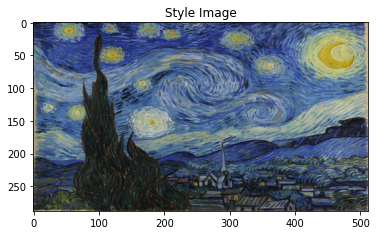

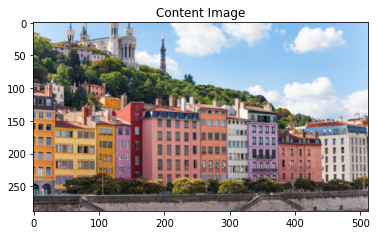

In [6]:
plot_tensor(style_img, title="Style Image")
plot_tensor(content_img, title="Content Image")

In [7]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [8]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

In [9]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [10]:
cnn = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()

In [11]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [12]:
content_layers_default = ["conv_4"]
style_layers_default = ["conv_1", "conv_2", "conv_3", "conv_4", "conv_5"]

def get_style_model_and_losses(
    cnn, 
    normalization_mean, 
    normalization_std,
    style_img, 
    content_img,
    content_layers=content_layers_default,
    style_layers=style_layers_default
):
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f"conv_{i}"
        elif isinstance(layer, nn.ReLU):
            name = f"relu_{i}"
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f"pool_{i}"
        elif isinstance(layer, nn.BatchNorm2d):
            name = f"bn_{i}"
        else:
            raise RuntimeError(f"Unrecognized layer: {layer.__class__.__name__}")

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [13]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [14]:
def run_style_transfer(
    cnn, 
    normalization_mean, 
    normalization_std,
    content_img, 
    style_img, 
    input_img, 
    output_path="./images/generated",
    num_steps=300,
    style_weight=1000000, 
    content_weight=1
):
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn,
        normalization_mean, 
        normalization_std, 
        style_img, 
        content_img
    )

    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    run = [0]
    while run[0] <= num_steps:

        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"[{run[0]}/{num_steps}] - Style[loss={style_score.item():4f}] - Content[loss={content_score.item():4f}]")
                save_image(input_img, os.path.join(output_path, f"output-{run[0]}.jpg"))

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_8388\634662619.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_8388\634662619.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


[50/300] - Style[loss=83.736931] - Content[loss=20.740406]
[100/300] - Style[loss=27.438633] - Content[loss=17.961243]
[150/300] - Style[loss=14.603408] - Content[loss=15.041992]
[200/300] - Style[loss=8.476301] - Content[loss=13.136958]
[250/300] - Style[loss=4.959678] - Content[loss=11.946667]
[300/300] - Style[loss=2.945193] - Content[loss=11.071345]


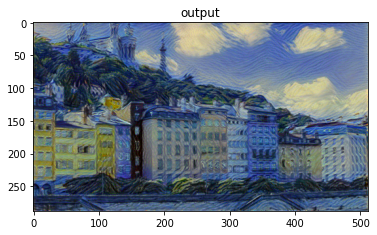

In [16]:
output = run_style_transfer(
    cnn, 
    cnn_normalization_mean, 
    cnn_normalization_std,
    content_img, 
    style_img, 
    content_img.clone()
)

plot_tensor(output, "output")

In [18]:
save_image(output, "./images/final/lyon-starry-night.jpg")

In [24]:
anim_file = './images/final/evolution.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
	filenames = glob.glob('./images/generated/output-*.jpg')
	filenames = sorted(filenames)
	for filename in filenames:
		image = imageio.v2.imread(filename)
		writer.append_data(image)
	image = imageio.v2.imread(filename)
	writer.append_data(image)